# Lab-5.1: Python GeoPandas & Folium

**Author**: Amit Arora

**Instructions** 

**Demonstration section:** The instructors will work through this section during the lab period. It is meant to be educational, with various code examples provided for you. You should understand all code in the demonstration section and should run the cells on your local machine before attempting the assignment

**Download**: ![Click here](lab-5.1.ipynb.zip) to download the notebook to follow along

**Submission:** No lab assignment this week, use the time to work on your projects. 

**NOTE**: It is recommended that you complete this `.ipynb` file in VS Code. Activate the `anly503` environment by selecting the kernel in the upper-right corner of VS-code. 

## Demonstration

Before starting the assignment, lets work through the various sub-components needed.

### Import

Install the `folium` package.

In [2]:
#!pip install folium==0.14.0 geopy==2.3.0 geopandas==0.12.2

In [3]:
import folium
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim
from folium.plugins import MarkerCluster
from folium.plugins import HeatMapWithTime

### Data

In [4]:
# Load the dataset
df = pd.read_parquet('https://bigdatateaching.s3.amazonaws.com/nyc-taxi-2016/nyc_taxi_2016.parquet')

## Exploratory Data Analysis



Let us get the shape of the dataframe to see the size of the data we are dealing with.


In [5]:
print(f"shape of the dataframe is {df.shape[0]:,}x{df.shape[1]}")

shape of the dataframe is 1,458,644x11


Note the `pickup_longitude`, `pickup_latitude`, `dropoff_longitude`, `dropoff_latitude` columns, these are the columns we would be using for plotting this dataset on a map.

In [6]:
## Down-sample (optional)
df=df.sample(frac=0.035)

print(f"shape of the dataframe is {df.shape[0]:,}x{df.shape[1]}")

shape of the dataframe is 51,053x11


In [7]:
# Preview the dataset
df.head()

id  vendor_id      pickup_datetime     dropoff_datetime  \
1074912  id1438307          1  2016-02-15 21:49:27  2016-02-15 21:56:24   
625053   id3288642          1  2016-05-21 23:49:44  2016-05-22 00:09:44   
238534   id1759948          1  2016-02-27 23:43:51  2016-02-27 23:48:12   
1152719  id2630642          2  2016-06-12 00:03:43  2016-06-12 00:12:55   
478617   id3222808          2  2016-01-27 12:14:47  2016-01-27 12:21:55   

         passenger_count  pickup_longitude  pickup_latitude  \
1074912                3        -73.986107        40.757629   
625053                 1        -73.984322        40.774734   
238534                 1        -73.969551        40.800468   
1152719                1        -73.983612        40.761101   
478617                 6        -73.990372        40.751110   

         dropoff_longitude  dropoff_latitude store_and_fwd_flag  trip_duration  
1074912         -73.977104         40.766350                  N            417  
625053          -73.947319         40.779247                  N           1200  
238534          -73.973595         40.788624                  N            261  
1152719         -73.963158         40.774242                  N            552  
478617          -73.979797         40.746410                  N            428

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51053 entries, 1074912 to 441708
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  51053 non-null  object 
 1   vendor_id           51053 non-null  int64  
 2   pickup_datetime     51053 non-null  object 
 3   dropoff_datetime    51053 non-null  object 
 4   passenger_count     51053 non-null  int64  
 5   pickup_longitude    51053 non-null  float64
 6   pickup_latitude     51053 non-null  float64
 7   dropoff_longitude   51053 non-null  float64
 8   dropoff_latitude    51053 non-null  float64
 9   store_and_fwd_flag  51053 non-null  object 
 10  trip_duration       51053 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 4.7+ MB


### GeoPandas

Let us first explore the dataset with `GeoPandas`. We start with plotting the pickup and dropoff locations as a simple scatter plot using `matplotlib`. Notice that these plots automatically resemble the shape of New York City.

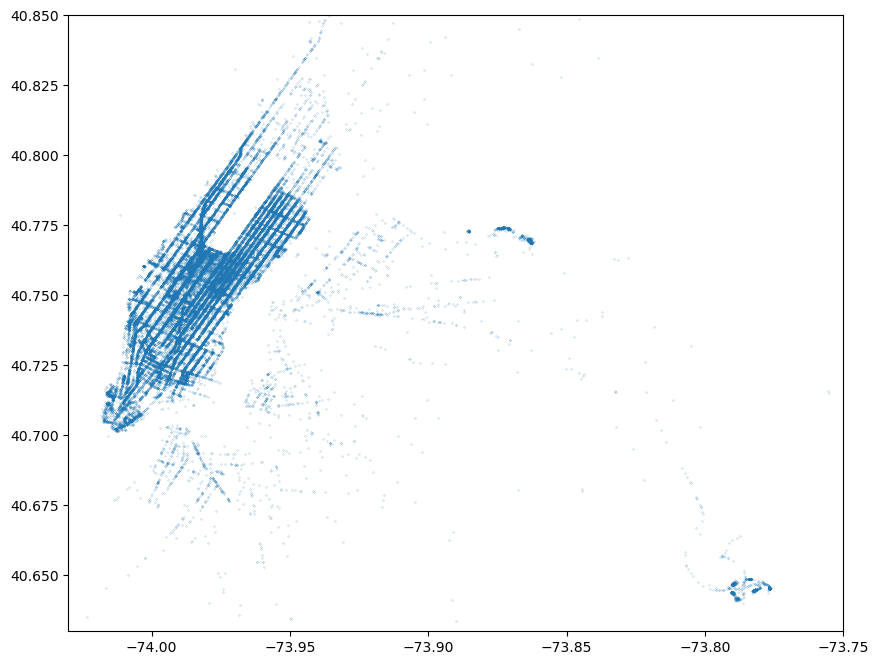

In [9]:
# visualizing passenger pickup locations
fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(10,8))
plt.ylim(40.63, 40.85)
plt.xlim(-74.03,-73.75)
ax.scatter(df['pickup_longitude'],df['pickup_latitude'], s=0.02, alpha=1)

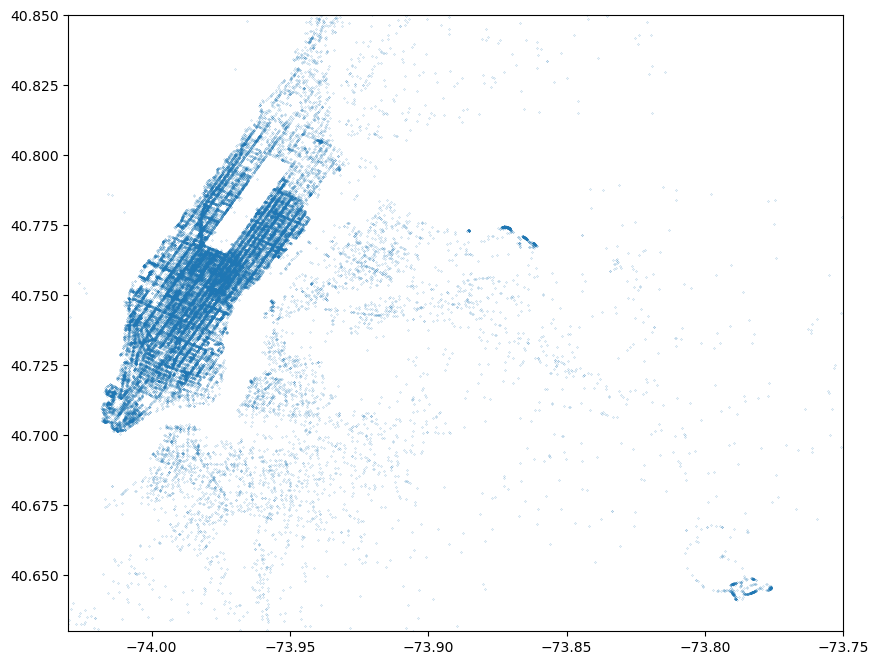

In [10]:
# visualizing passenger dropoff locations
fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(10,8))
plt.ylim(40.63, 40.85)
plt.xlim(-74.03,-73.75)
ax.scatter(df['dropoff_longitude'],df['dropoff_latitude'], s=0.02, alpha=1)

Now let us use `GeoPandas` to plot the New York City burroughs, this is easy because `GeoPandas` comes with the `nybb` dataset that has the geometry/shape information to do this.

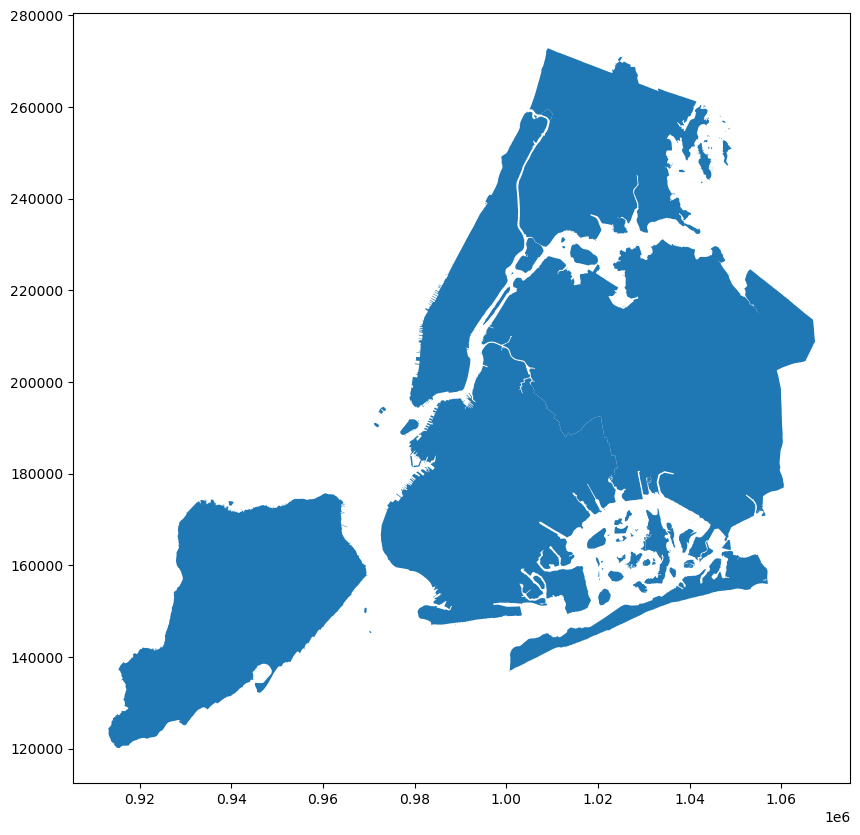

In [11]:
# getting New York City map from Geopandas
nyc = gpd.read_file(gpd.datasets.get_path('nybb'))
ax = nyc.plot(figsize=(12, 10))

We can do this better by using the shape files available from `https://data.cityofnewyork.us/api/geospatial/d3c5-ddgc?method=export&format=Shapefile` in the form of a single zip file. The zip file actually contains 4 files and we need all 4 of them. To make things easier, the 4 files have already been downloaded and made available in the [datasets](https://github.com/anly503/datasets) repo so here we are just going to download these files from there.

In [12]:
import requests
import os

shape_files = ['https://github.com/anly503/datasets/raw/main/nyc-shape-files/geo_export_0c35ce5c-c15b-46b5-9303-1c5a64b2472d.shp',
               'https://github.com/anly503/datasets/raw/main/nyc-shape-files/geo_export_0c35ce5c-c15b-46b5-9303-1c5a64b2472d.dbf',
               'https://raw.githubusercontent.com/anly503/datasets/main/nyc-shape-files/geo_export_0c35ce5c-c15b-46b5-9303-1c5a64b2472d.prj',
               'https://github.com/anly503/datasets/raw/main/nyc-shape-files/geo_export_0c35ce5c-c15b-46b5-9303-1c5a64b2472d.shx']

for f in shape_files:
    r = requests.get(f, allow_redirects=True)
    open(os.path.basename(f), 'wb').write(r.content)

In [13]:
zones = gpd.read_file('geo_export_0c35ce5c-c15b-46b5-9303-1c5a64b2472d.shp').to_crs({'init' :'epsg:4326'})
zones.head()

c:\Users\Dan Lim\miniconda3\envs\ANLY503\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


borough  location_i  objectid  shape_area  shape_leng  \
0            EWR         1.0       1.0    0.000782    0.116357   
1         Queens         2.0       2.0    0.004866    0.433470   
2          Bronx         3.0       3.0    0.000314    0.084341   
3      Manhattan         4.0       4.0    0.000112    0.043567   
4  Staten Island         5.0       5.0    0.000498    0.092146   

                      zone                                           geometry  
0           Newark Airport  POLYGON ((-74.18445 40.69500, -74.18449 40.695...  
1              Jamaica Bay  MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...  
2  Allerton/Pelham Gardens  POLYGON ((-73.84793 40.87134, -73.84725 40.870...  
3            Alphabet City  POLYGON ((-73.97177 40.72582, -73.97179 40.725...  
4            Arden Heights  POLYGON ((-74.17422 40.56257, -74.17349 40.562...

Now plot the map and colorize by boroughs.

<AxesSubplot: >

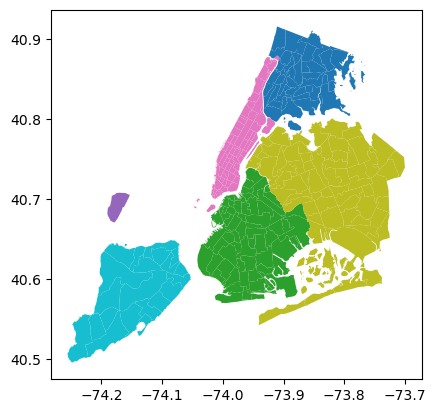

In [14]:
zones.plot(column='borough', categorical=True)

#### Find out the zones and boroughs that form the most common pickup and dropoff locations

To do this, we will convert our Pandas dataframe into a `GeoPandas` dataframe (see [this](https://geopandas.org/en/stable/gallery/create_geopandas_from_pandas.html) link) and then join it with the zones dataframe so that for each trip (row of the dataframe) we have the pickup and dropoff zone and borough. 

1. We have to do this in two steps, once for the pickup location and once for the dropoff locations because a geopandas dataframe can have a single geometry column at a time.

1. We will join the geopandas dataframe with the zones dataframe using [`sjoin`](https://geopandas.org/en/stable/docs/reference/api/geopandas.sjoin.html) and we use the predicate `within` to say that if a pickup/dropoff location is within the polygon of a zones dataframe row then that is when the join happens.

In [15]:
geo_df_pu = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.pickup_longitude, df.pickup_latitude), crs={'init' :'epsg:4326'})
geo_df_pu.head()

c:\Users\Dan Lim\miniconda3\envs\ANLY503\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


id  vendor_id      pickup_datetime     dropoff_datetime  \
1074912  id1438307          1  2016-02-15 21:49:27  2016-02-15 21:56:24   
625053   id3288642          1  2016-05-21 23:49:44  2016-05-22 00:09:44   
238534   id1759948          1  2016-02-27 23:43:51  2016-02-27 23:48:12   
1152719  id2630642          2  2016-06-12 00:03:43  2016-06-12 00:12:55   
478617   id3222808          2  2016-01-27 12:14:47  2016-01-27 12:21:55   

         passenger_count  pickup_longitude  pickup_latitude  \
1074912                3        -73.986107        40.757629   
625053                 1        -73.984322        40.774734   
238534                 1        -73.969551        40.800468   
1152719                1        -73.983612        40.761101   
478617                 6        -73.990372        40.751110   

         dropoff_longitude  dropoff_latitude store_and_fwd_flag  \
1074912         -73.977104         40.766350                  N   
625053          -73.947319         40.779247                  N   
238534          -73.973595         40.788624                  N   
1152719         -73.963158         40.774242                  N   
478617          -73.979797         40.746410                  N   

         trip_duration                    geometry  
1074912            417  POINT (-73.98611 40.75763)  
625053            1200  POINT (-73.98432 40.77473)  
238534             261  POINT (-73.96955 40.80047)  
1152719            552  POINT (-73.98361 40.76110)  
478617             428  POINT (-73.99037 40.75111)

In [16]:
geo_df_pu = gpd.sjoin(geo_df_pu, zones[['zone', 'borough', 'geometry']], how="left", predicate="within")

geo_df_pu.drop(['geometry', 'index_right'], axis=1, inplace=True)
geo_df_pu.rename({"zone": "zone_pu", "borough": "borough_pu"}, axis=1, inplace=True)

geo_df_pu.head()

id  vendor_id      pickup_datetime     dropoff_datetime  \
1074912  id1438307          1  2016-02-15 21:49:27  2016-02-15 21:56:24   
625053   id3288642          1  2016-05-21 23:49:44  2016-05-22 00:09:44   
238534   id1759948          1  2016-02-27 23:43:51  2016-02-27 23:48:12   
1152719  id2630642          2  2016-06-12 00:03:43  2016-06-12 00:12:55   
478617   id3222808          2  2016-01-27 12:14:47  2016-01-27 12:21:55   

         passenger_count  pickup_longitude  pickup_latitude  \
1074912                3        -73.986107        40.757629   
625053                 1        -73.984322        40.774734   
238534                 1        -73.969551        40.800468   
1152719                1        -73.983612        40.761101   
478617                 6        -73.990372        40.751110   

         dropoff_longitude  dropoff_latitude store_and_fwd_flag  \
1074912         -73.977104         40.766350                  N   
625053          -73.947319         40.779247                  N   
238534          -73.973595         40.788624                  N   
1152719         -73.963158         40.774242                  N   
478617          -73.979797         40.746410                  N   

         trip_duration                    zone_pu borough_pu  
1074912            417  Times Sq/Theatre District  Manhattan  
625053            1200        Lincoln Square East  Manhattan  
238534             261           Manhattan Valley  Manhattan  
1152719            552  Times Sq/Theatre District  Manhattan  
478617             428           Garment District  Manhattan

In [17]:
geo_df_do = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.dropoff_longitude, df.dropoff_latitude), crs={'init' :'epsg:4326'})
geo_df_do.head()

c:\Users\Dan Lim\miniconda3\envs\ANLY503\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


id  vendor_id      pickup_datetime     dropoff_datetime  \
1074912  id1438307          1  2016-02-15 21:49:27  2016-02-15 21:56:24   
625053   id3288642          1  2016-05-21 23:49:44  2016-05-22 00:09:44   
238534   id1759948          1  2016-02-27 23:43:51  2016-02-27 23:48:12   
1152719  id2630642          2  2016-06-12 00:03:43  2016-06-12 00:12:55   
478617   id3222808          2  2016-01-27 12:14:47  2016-01-27 12:21:55   

         passenger_count  pickup_longitude  pickup_latitude  \
1074912                3        -73.986107        40.757629   
625053                 1        -73.984322        40.774734   
238534                 1        -73.969551        40.800468   
1152719                1        -73.983612        40.761101   
478617                 6        -73.990372        40.751110   

         dropoff_longitude  dropoff_latitude store_and_fwd_flag  \
1074912         -73.977104         40.766350                  N   
625053          -73.947319         40.779247                  N   
238534          -73.973595         40.788624                  N   
1152719         -73.963158         40.774242                  N   
478617          -73.979797         40.746410                  N   

         trip_duration                    geometry  
1074912            417  POINT (-73.97710 40.76635)  
625053            1200  POINT (-73.94732 40.77925)  
238534             261  POINT (-73.97359 40.78862)  
1152719            552  POINT (-73.96316 40.77424)  
478617             428  POINT (-73.97980 40.74641)

In [18]:
geo_df_do = gpd.sjoin(geo_df_do, zones[['zone', 'borough', 'geometry']], how="left", predicate="within")

geo_df_do.drop(['geometry', 'index_right'], axis=1, inplace=True)
geo_df_do.rename({"zone": "zone_do", "borough": "borough_do"}, axis=1, inplace=True)

geo_df_do.head()

id  vendor_id      pickup_datetime     dropoff_datetime  \
1074912  id1438307          1  2016-02-15 21:49:27  2016-02-15 21:56:24   
625053   id3288642          1  2016-05-21 23:49:44  2016-05-22 00:09:44   
238534   id1759948          1  2016-02-27 23:43:51  2016-02-27 23:48:12   
1152719  id2630642          2  2016-06-12 00:03:43  2016-06-12 00:12:55   
478617   id3222808          2  2016-01-27 12:14:47  2016-01-27 12:21:55   

         passenger_count  pickup_longitude  pickup_latitude  \
1074912                3        -73.986107        40.757629   
625053                 1        -73.984322        40.774734   
238534                 1        -73.969551        40.800468   
1152719                1        -73.983612        40.761101   
478617                 6        -73.990372        40.751110   

         dropoff_longitude  dropoff_latitude store_and_fwd_flag  \
1074912         -73.977104         40.766350                  N   
625053          -73.947319         40.779247                  N   
238534          -73.973595         40.788624                  N   
1152719         -73.963158         40.774242                  N   
478617          -73.979797         40.746410                  N   

         trip_duration                zone_do borough_do  
1074912            417           Central Park  Manhattan  
625053            1200         Yorkville East  Manhattan  
238534             261  Upper West Side North  Manhattan  
1152719            552  Upper East Side South  Manhattan  
478617             428            Murray Hill  Manhattan

Now we will combine the pickup and dropoff dataframes so that we have the zone and borough for both pickup and dropoff locations.

In [19]:
gdf_pu_do = pd.merge(geo_df_do, geo_df_pu, how="inner")
gdf_pu_do

id  vendor_id      pickup_datetime     dropoff_datetime  \
0      id1438307          1  2016-02-15 21:49:27  2016-02-15 21:56:24   
1      id3288642          1  2016-05-21 23:49:44  2016-05-22 00:09:44   
2      id1759948          1  2016-02-27 23:43:51  2016-02-27 23:48:12   
3      id2630642          2  2016-06-12 00:03:43  2016-06-12 00:12:55   
4      id3222808          2  2016-01-27 12:14:47  2016-01-27 12:21:55   
...          ...        ...                  ...                  ...   
51048  id1466660          2  2016-05-05 20:26:52  2016-05-05 20:34:34   
51049  id3159854          1  2016-03-11 23:56:43  2016-03-12 00:13:00   
51050  id0700957          2  2016-05-07 23:18:55  2016-05-07 23:34:10   
51051  id1448882          2  2016-06-22 21:11:18  2016-06-22 21:27:25   
51052  id0825331          2  2016-05-27 10:10:45  2016-05-27 10:25:53   

       passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                    3        -73.986107        40.757629         -73.977104   
1                    1        -73.984322        40.774734         -73.947319   
2                    1        -73.969551        40.800468         -73.973595   
3                    1        -73.983612        40.761101         -73.963158   
4                    6        -73.990372        40.751110         -73.979797   
...                ...               ...              ...                ...   
51048                4        -73.962631        40.757229         -73.954369   
51049                1        -73.985710        40.747154         -73.987846   
51050                5        -73.956497        40.787010         -73.915863   
51051                1        -73.985886        40.758385         -73.965324   
51052                1        -74.002510        40.747890         -73.986092   

       dropoff_latitude store_and_fwd_flag  trip_duration  \
0             40.766350                  N            417   
1             40.779247                  N           1200   
2             40.788624                  N            261   
3             40.774242                  N            552   
4             40.746410                  N            428   
...                 ...                ...            ...   
51048         40.774780                  N            462   
51049         40.721104                  N            977   
51050         40.826710                  N            915   
51051         40.800865                  N            967   
51052         40.746719                  N            908   

                                zone_do borough_do  \
0                          Central Park  Manhattan   
1                        Yorkville East  Manhattan   
2                 Upper West Side North  Manhattan   
3                 Upper East Side South  Manhattan   
4                           Murray Hill  Manhattan   
...                                 ...        ...   
51048                    Yorkville West  Manhattan   
51049                   Lower East Side  Manhattan   
51050  East Concourse/Concourse Village      Bronx   
51051                      Bloomingdale  Manhattan   
51052                     Midtown South  Manhattan   

                             zone_pu borough_pu  
0          Times Sq/Theatre District  Manhattan  
1                Lincoln Square East  Manhattan  
2                   Manhattan Valley  Manhattan  
3          Times Sq/Theatre District  Manhattan  
4                   Garment District  Manhattan  
...                              ...        ...  
51048  Sutton Place/Turtle Bay North  Manhattan  
51049                  Midtown South  Manhattan  
51050                   Central Park  Manhattan  
51051      Times Sq/Theatre District  Manhattan  
51052                   East Chelsea  Manhattan  

[51053 rows x 15 columns]

Counts for pickup and droppoff locations considering both zone and borough. This is a long tailed distribution as even the most frequently occuring combination only accounts of 0.5% of the total trips.

In [20]:
gdf_pu_do.value_counts(["zone_pu", "borough_pu", "zone_do", "borough_do"], normalize=True).mul(100).reset_index(name="trips")

zone_pu borough_pu                   zone_do  \
0           Upper East Side North  Manhattan     Upper East Side North   
1           Upper East Side South  Manhattan     Upper East Side North   
2           Upper East Side North  Manhattan     Upper East Side South   
3           Upper East Side South  Manhattan     Upper East Side South   
4           Upper East Side South  Manhattan              Midtown East   
...                           ...        ...                       ...   
5911  Downtown Brooklyn/MetroTech   Brooklyn      Flatbush/Ditmas Park   
5912  Downtown Brooklyn/MetroTech   Brooklyn  Financial District South   
5913  Downtown Brooklyn/MetroTech   Brooklyn  Financial District North   
5914  Downtown Brooklyn/MetroTech   Brooklyn              East Chelsea   
5915                Alphabet City  Manhattan             Alphabet City   

     borough_do     trips  
0     Manhattan  0.483006  
1     Manhattan  0.457482  
2     Manhattan  0.455518  
3     Manhattan  0.392688  
4     Manhattan  0.267028  
...         ...       ...  
5911   Brooklyn  0.001963  
5912  Manhattan  0.001963  
5913  Manhattan  0.001963  
5914  Manhattan  0.001963  
5915  Manhattan  0.001963  

[5916 rows x 5 columns]

Counts for pickup and droppoff locations considering only the borough. This is interesting because **87% of the trips start and end in Manhattan**.

In [21]:
gdf_pu_do_borough = gdf_pu_do.value_counts(["borough_pu", "borough_do"], normalize=True).mul(100).reset_index(name="trips")
gdf_pu_do_borough["pu_do"] = gdf_pu_do_borough["borough_pu"] + " to " + gdf_pu_do_borough["borough_do"]
gdf_pu_do_borough

borough_pu     borough_do      trips                           pu_do
0       Manhattan      Manhattan  84.632149          Manhattan to Manhattan
1       Manhattan         Queens   3.526340             Manhattan to Queens
2       Manhattan       Brooklyn   3.463509           Manhattan to Brooklyn
3          Queens      Manhattan   3.392826             Queens to Manhattan
4          Queens         Queens   1.545228                Queens to Queens
5        Brooklyn       Brooklyn   1.156467            Brooklyn to Brooklyn
6          Queens       Brooklyn   0.759852              Queens to Brooklyn
7       Manhattan          Bronx   0.522275              Manhattan to Bronx
8        Brooklyn      Manhattan   0.465335           Brooklyn to Manhattan
9       Manhattan            EWR   0.149221                Manhattan to EWR
10       Brooklyn         Queens   0.135477              Brooklyn to Queens
11         Queens          Bronx   0.096209                 Queens to Bronx
12          Bronx          Bronx   0.062830                  Bronx to Bronx
13          Bronx      Manhattan   0.033378              Bronx to Manhattan
14         Queens  Staten Island   0.013744         Queens to Staten Island
15      Manhattan  Staten Island   0.011781      Manhattan to Staten Island
16          Bronx         Queens   0.009817                 Bronx to Queens
17         Queens            EWR   0.007854                   Queens to EWR
18       Brooklyn          Bronx   0.005890               Brooklyn to Bronx
19  Staten Island  Staten Island   0.005890  Staten Island to Staten Island
20            EWR            EWR   0.003927                      EWR to EWR

In [22]:

import plotly.express as px

fig = px.bar(gdf_pu_do_borough, x="pu_do", y="trips")
fig.show()

### Folium

We will start with a base map of New York City and then add a subset of the data (trips) to the map.

In [23]:
default_location = [40.693943, -73.985880]
default_zoom_start = 11
base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
base_map

Now lets add some trip data to the map, because there are close to 1.5 million trip, we will plot only a very small fraction of those. There are other techniques to use when plotting so many data points on a map.

In [24]:
# Add markers for pickups and dropoffs
frac = 0.0001
base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
for index, row in df.sample(frac=frac).iterrows():
    folium.Marker([row['pickup_latitude'],
                   row['pickup_longitude']],
                   icon=folium.Icon(color='blue'),
                   tooltip=f'{row["id"]}').add_to(base_map)
    folium.Marker([row['dropoff_latitude'],
                   row['dropoff_longitude']],
                   icon=folium.Icon(color='red'),
                   tooltip=f'{row["id"]}').add_to(base_map)
base_map

Clearly, there are too many markers on this plot for it to be useful, even with the tooltip (and we can add more information to the tooltip). Folium also provides the option of creating a `MarkerCluster` where a bunch of markers that are close by get grouped together and then we can zoom in to see individual markers.

More details on `MarkerCluster` is available on the Leaflet GitHub page for [cluster methods](https://github.com/Leaflet/Leaflet.markercluster/blob/master/README.md#clusters-methods). Customization of `MarkerCluster` may require some JavaScript, see [this](https://stackoverflow.com/questions/72222835/folium-put-markers-in-marker-clusters-and-in-layers-based-on-a-value), [this](https://stackoverflow.com/questions/24258914/leaflet-clustermarker-with-custom-icon) and [this](https://stackoverflow.com/questions/52428916/python-folium-markercluster-color-customization) StackOverflow posts.

In [25]:
base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)

# create a marker cluster called "NYC Trips"
marker_cluster = MarkerCluster().add_to(base_map)
for index, row in df.sample(frac=frac).iterrows():
    folium.Marker([row['pickup_latitude'],
                   row['pickup_longitude']],
                   icon=folium.Icon(color='blue'),
                   tooltip=f'{row["id"]}').add_to(marker_cluster)
    folium.Marker([row['dropoff_latitude'],
                   row['dropoff_longitude']],
                   icon=folium.Icon(color='red'),
                   tooltip=f'{row["id"]}').add_to(marker_cluster)
base_map

A Heatmap is a good option for exploring the density of where the pickups and droppoffs are located. We will make a heatmap for the pickup locations next. The folium `HeatMap` function does that for us. The `Heatmap` function requires a `list` in the following format `[[lat, lng, count], [lat, lng, count],...,[lat, lng, count]]`.

In [26]:
df_pickup_location_counts = df.value_counts(['pickup_latitude', 'pickup_longitude']).reset_index(name='counts')

base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
HeatMap(data=df_pickup_location_counts.values.tolist(), radius=8, max_zoom=13).add_to(base_map)
base_map

Ok, now it would be interesting to visualize the most common pickup and dropoff points combination. We have to handle to problems before we can do that:

1. A lot of the trips have the same pickup and dropoff latitude and longitude, probably because the trips got cancelled or maybe problems with the data, so we need to exclude those.

1. Maybe the exact location in terms of latitude and longitude for different trips may not be the same but they are probably in the same general area, so we should count them as one location for the purpose of finding the most common pickup and dropoff points combination. To do this, we convert the latitude and longitude to a coarse version by just rounding them off to 2 or 3 decimal places. 

In [27]:
location_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']
location_coarse_cols = [c + "_coarse" for c in location_cols]
df_trips_that_happened = df[(df.pickup_longitude != df.dropoff_longitude) & (df.pickup_latitude != df.dropoff_latitude)]
for loc_col, loc_coarse_col in zip(location_cols, location_coarse_cols):
    df_trips_that_happened[loc_coarse_col] = round(df_trips_that_happened[loc_col], 2)
df_trips_that_happened.head()

C:\Users\Dan Lim\AppData\Local\Temp\ipykernel_16972\2537938070.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Dan Lim\AppData\Local\Temp\ipykernel_16972\2537938070.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Dan Lim\AppData\Local\Temp\ipykernel_16972\2537938070.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

id  vendor_id      pickup_datetime     dropoff_datetime  \
1074912  id1438307          1  2016-02-15 21:49:27  2016-02-15 21:56:24   
625053   id3288642          1  2016-05-21 23:49:44  2016-05-22 00:09:44   
238534   id1759948          1  2016-02-27 23:43:51  2016-02-27 23:48:12   
1152719  id2630642          2  2016-06-12 00:03:43  2016-06-12 00:12:55   
478617   id3222808          2  2016-01-27 12:14:47  2016-01-27 12:21:55   

         passenger_count  pickup_longitude  pickup_latitude  \
1074912                3        -73.986107        40.757629   
625053                 1        -73.984322        40.774734   
238534                 1        -73.969551        40.800468   
1152719                1        -73.983612        40.761101   
478617                 6        -73.990372        40.751110   

         dropoff_longitude  dropoff_latitude store_and_fwd_flag  \
1074912         -73.977104         40.766350                  N   
625053          -73.947319         40.779247                  N   
238534          -73.973595         40.788624                  N   
1152719         -73.963158         40.774242                  N   
478617          -73.979797         40.746410                  N   

         trip_duration                    geometry  pickup_latitude_coarse  \
1074912            417  POINT (-73.97710 40.76635)                   40.76   
625053            1200  POINT (-73.94732 40.77925)                   40.77   
238534             261  POINT (-73.97359 40.78862)                   40.80   
1152719            552  POINT (-73.96316 40.77424)                   40.76   
478617             428  POINT (-73.97980 40.74641)                   40.75   

         pickup_longitude_coarse  dropoff_latitude_coarse  \
1074912                   -73.99                    40.77   
625053                    -73.98                    40.78   
238534                    -73.97                    40.79   
1152719                   -73.98                    40.77   
478617                    -73.99                    40.75   

         dropoff_longitude_coarse  
1074912                    -73.98  
625053                     -73.95  
238534                     -73.97  
1152719                    -73.96  
478617                     -73.98

Now that we have the coarse location, lets do a value count to find most frequently occuring pickup and dropoff combinations.

In [28]:
df_pickup_dropoff_location_counts = df_trips_that_happened.value_counts(location_coarse_cols).reset_index(name='counts')
df_pickup_dropoff_location_counts

pickup_latitude_coarse  pickup_longitude_coarse  \
0                      40.75                   -73.99   
1                      40.75                   -73.99   
2                      40.76                   -73.98   
3                      40.76                   -73.97   
4                      40.76                   -73.97   
...                      ...                      ...   
7163                   40.74                   -73.99   
7164                   40.74                   -73.99   
7165                   40.74                   -73.99   
7166                   40.74                   -73.99   
7167                   41.30                   -72.92   

      dropoff_latitude_coarse  dropoff_longitude_coarse  counts  
0                       40.76                    -73.98     282  
1                       40.75                    -73.98     250  
2                       40.75                    -73.99     241  
3                       40.77                    -73.96     235  
4                       40.75                    -73.98     221  
...                       ...                       ...     ...  
7163                    40.65                    -73.80       1  
7164                    40.65                    -74.01       1  
7165                    40.64                    -73.96       1  
7166                    40.63                    -74.02       1  
7167                    41.30                    -72.92       1  

[7168 rows x 5 columns]

Now just one more step before we put the markers on our `HeatMap` for the most common pickup and dropoff combinations. We would like to identify these locations by name so that they make a lot more sense to us than just plain old latitude longitude numbers. We do this using the `geopy` package as shown in the code below.

In [29]:
pu_lat = df_pickup_dropoff_location_counts.iloc[0]['pickup_latitude_coarse']
pu_lng = df_pickup_dropoff_location_counts.iloc[0]['pickup_longitude_coarse']
do_lat = df_pickup_dropoff_location_counts.iloc[0]['dropoff_latitude_coarse']
do_lng = df_pickup_dropoff_location_counts.iloc[0]['dropoff_longitude_coarse']

# Initialize Nominatim API
geolocator = Nominatim(user_agent="lab-5.1")

# Get location with geocode
pu_location = geolocator.geocode(f"{pu_lat},{pu_lng}")
do_location = geolocator.geocode(f"{do_lat},{do_lng}")
 
# Display location
print(f"most common trip pickup and dropoff are pickup from \"{pu_location}\" and dropoff at \"{do_location}\"")

most common trip pickup and dropoff are pickup from "137, West 33rd Street, Chelsea District, Manhattan, New York County, City of New York, New York, 10001, United States" and dropoff at "Rockefeller Center, 45, Rockefeller Plaza, Manhattan Community Board 5, Manhattan, New York County, City of New York, New York, 10111, United States"


All set to add the markers on the `HeatMap`.

In [30]:
folium.Marker([pu_lat, pu_lng], icon=folium.Icon(color='blue'), tooltip=f'Pickup from {pu_location[:20]}').add_to(base_map)
folium.Marker([do_lat, do_lng], icon=folium.Icon(color='red'), tooltip=f'Dropoff at {do_location[:20]}').add_to(base_map)
base_map

Let's create one more map, this is a `HeatMap` that animates over time. Lets choose hour of day as our time scale.

In [31]:
df.pickup_datetime = pd.to_datetime(df.pickup_datetime, format='%Y-%m-%d %H:%M:%S')
df['hour'] = df.pickup_datetime.apply(lambda x: x.hour)

In [32]:
df['count'] = 1
df_hour_list = []
for hour in df.hour.sort_values().unique():
    df_hour_list.append(df.loc[df.hour == hour, ['pickup_latitude', 'pickup_longitude', 'count']].groupby(['pickup_latitude', 'pickup_longitude']).sum().reset_index().values.tolist())

In [33]:
base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
HeatMapWithTime(df_hour_list, radius=5, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}, min_opacity=0.5, max_opacity=0.8, use_local_extrema=True).add_to(base_map)
base_map

## Lab Submission

There is no submission for this lab :).